We first clone and install the required packages from the [GitHub repository](https://github.com/time-series-foundation-models/lag-llama/) that has the Lag-Llama architecture.



In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 71 (delta 25), reused 54 (delta 14), pack-reused 0
Receiving objects: 100% (71/71), 169.42 KiB | 4.98 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [2]:
cd lag-llama

/content/lag-llama


In [3]:
!pip install -r requirements.txt --quiet # this could take some time

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.8/257.8 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 

We then download our pretrained model weights from [HuggingFace](https://huggingface.co/time-series-foundation-models/Lag-Llama) 🤗

In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_errors.py", line 286, in hf_raise_for_status
    response.raise_for_status()
  File "/usr/local/lib/python3.10/dist-packages/requests/models.py", line 1021, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 503 Server Error: Service Temporarily Unavailable for url: https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py", line 1238, in hf_hub_download
    metadata = get_hf_file_metadata(
  File "/usr/local/lib/python3.10/dist-packages/huggingfa

We import the required packages and the lag llama estimator object which we can use to make predictions.

We download the [Melbourne Pedestrian Counts](https://zenodo.org/records/3898350) dataset used in our [paper](https://time-series-foundation-models.github.io/lag-llama.pdf). This is a dataset that the model has never seen before.

We then set the forecast length of the dataset for inference. Here we use the default prediction length of the dataset (48).

Note how the frequency of the dataset does not matter, since lag-llama can (train and) perform inference with any data of any frequency.

We create a model object with the hyperparameters from the pretrained model, and the prediction length.

In [3]:
!gdown https://drive.google.com/uc?id=18sra_8u1BZZWAzAabuMzzF_BNQmjprfl

/bin/bash: line 1: gdown: command not found


In [4]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='66')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=48)

In [11]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from lag_llama.gluon.estimator import LagLlamaEstimator
dataset = get_dataset("pedestrian_counts")

backtest_dataset = dataset.test
training_dataset = dataset.train
prediction_length = dataset.metadata.prediction_length
context_length = 32
from gluonts.dataset.loader import TrainDataLoader
from gluonts.itertools import Cached
from gluonts.torch.batchify import batchify
batch_size = 32
num_batches_per_epoch = 50
ckpt = torch.load("checkpoints/lag-llama.ckpt", map_location=torch.device('cuda:0'))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
estimator = LagLlamaEstimator(
    # ckpt_path="checkpoints/lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,
    # estimator args
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
)

lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

In [12]:
print(next(iter(dataset.train)), "\n" ,next(iter(dataset.test))) 

{'target': array([53., 43., 10., ..., 37., 51., 21.], dtype=float32), 'start': Period('2009-05-01 00:00', 'H'), 'item_id': 'T1', 'feat_static_cat': array([0], dtype=int32)} 
 {'target': array([53., 43., 10., ..., 25., 32., 27.], dtype=float32), 'start': Period('2009-05-01 00:00', 'H'), 'item_id': 'T1', 'feat_static_cat': array([0], dtype=int32)}


In [13]:
estimator_args["time_feat"]

True

In [18]:
from pytorch_lightning import Trainer
trainer = Trainer(max_epochs=100)
trainer.fit(lightning_module, estimator.create_training_data_loader(dataset.train, lightning_module))

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


None


KeyError: 'time_feat'

We perform inference on this dataset zero-shot!

In [6]:
import numpy as np
import pandas as pd

from gluonts.dataset.field_names import FieldName
from gluonts.dataset.artificial import ComplexSeasonalTimeSeries
from gluonts.dataset.common import ListDataset
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.util import to_pandas

In [9]:
df = pd.read_hdf("metr-la.h5")

FileNotFoundError: File metr-la.h5 does not exist

In [22]:
ndf = df.reset_index(drop=True)

In [23]:
sensors = ndf.transpose().index.tolist()

In [21]:
periods = []
for _ in range(len(df.columns)):
    periods.append(pd.Period("01-03-2012", freq="5min"))

In [24]:
ndf = ndf.transpose()

In [26]:
custom_ds_metadata = {
    "prediction_length": 12,
    "freq": "1min",
    "start": periods,
}

In [27]:
def create_dataset():
    # create target: noise + pattern
    # noise
    # noise = np.random.normal(mu, sigma, size=(num_series, num_steps))

    # # pattern - sinusoid with different phase
    # sin_minusPi_Pi = np.sin(
    #     np.tile(np.linspace(-np.pi, np.pi, period), int(num_steps / period))
    # )
    # sin_Zero_2Pi = np.sin(
    #     np.tile(np.linspace(0, 2 * np.pi, 24), int(num_steps / period))
    # )

    # pattern = np.concatenate(
    #     (
    #         np.tile(sin_minusPi_Pi.reshape(1, -1), (int(np.ceil(num_series / 2)), 1)),
    #         np.tile(sin_Zero_2Pi.reshape(1, -1), (int(np.floor(num_series / 2)), 1)),
    #     ),
    #     axis=0,
    # )

    target = ndf.values

    # create time features: use target one period earlier, append with zeros
    feat_dynamic_real = np.zeros_like(target)

    # create categorical static feats: use the sinusoid type as a categorical feature
    feat_static_cat = np.zeros(target.shape[1])
    return target, feat_dynamic_real, feat_static_cat

In [29]:
data_out = create_dataset(
)

In [30]:
target, feat_dynamic_real, feat_static_cat = data_out

In [31]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr],
            FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for (target, start, fdr, fsc) in zip(
            target[:, : -custom_ds_metadata["prediction_length"]],
            custom_ds_metadata["start"],
            feat_dynamic_real[:, : -custom_ds_metadata["prediction_length"]],
            feat_static_cat,
        )
    ],
    freq=custom_ds_metadata["freq"],
)

test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr],
            FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for (target, start, fdr, fsc) in zip(
            target, custom_ds_metadata["start"], feat_dynamic_real, feat_static_cat
        )
    ],
    freq=custom_ds_metadata["freq"],
)

In [33]:
train_entry = next(iter(train_ds))
train_entry.keys()
import matplotlib.pyplot as plt

In [6]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
)

NameError: name 'test_ds' is not defined

In [7]:
backtest_dataset

Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x7f5c5a930850>, iterable=JsonLinesFile(path=PosixPath('/home/seyed/.gluonts/datasets/pedestrian_counts/test/data.json.gz'), start=0, n=None))

In [8]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=predictor,
)

window_length: 48


In [10]:
forecasts = list(forecast_it)
tss = list(ts_it)

forward () {'past_target': tensor([[  18.,   28.,  110.,  ...,   37.,   51.,   21.],
        [   9.,   22.,   71.,  ...,   31.,   24.,   26.],
        [  43.,   92.,  166.,  ...,  121.,   98.,   99.],
        ...,
        [  41.,   23.,   74.,  ...,   35.,   44.,   22.],
        [  20.,   20.,   35.,  ...,   34.,   27.,   19.],
        [  33.,   59.,  190.,  ..., 1522., 1414., 1544.]], device='cuda:0'), 'past_observed_values': tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0'), 'past_time_feat': tensor([[[-0.5000, -0.5000,  0.5000,  0.0000,  0.3000,  0.3137],
         [-0.5000, -0.5000, -0.5000,  0.1667,  0.3333,  0.3164],
         [-0.5000, -0.5000, -0.4565,  0.1667,  0.3333,  0.3164],
         ...,
         [-0.5000, -0.5000,  0.1957, -0.3333, -0.1667,  0.4425],
     

We obtain some metrics for our reference. The CRPS metric is a commonly used metric in time series forecasting literature. We obtain a CRPS of **0.2531** with this dataset (close to the number reported in Table 1 of the [paper](https://time-series-foundation-models.github.io/lag-llama.pdf)).

In [37]:
evaluator = Evaluator()

In [38]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 207it [00:00, 6308.55it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [39]:
print("CRPS:", agg_metrics['mean_wQuantileLoss'])

CRPS: 0.08729592451058753


We plot the forecasts of our model on this dataset.

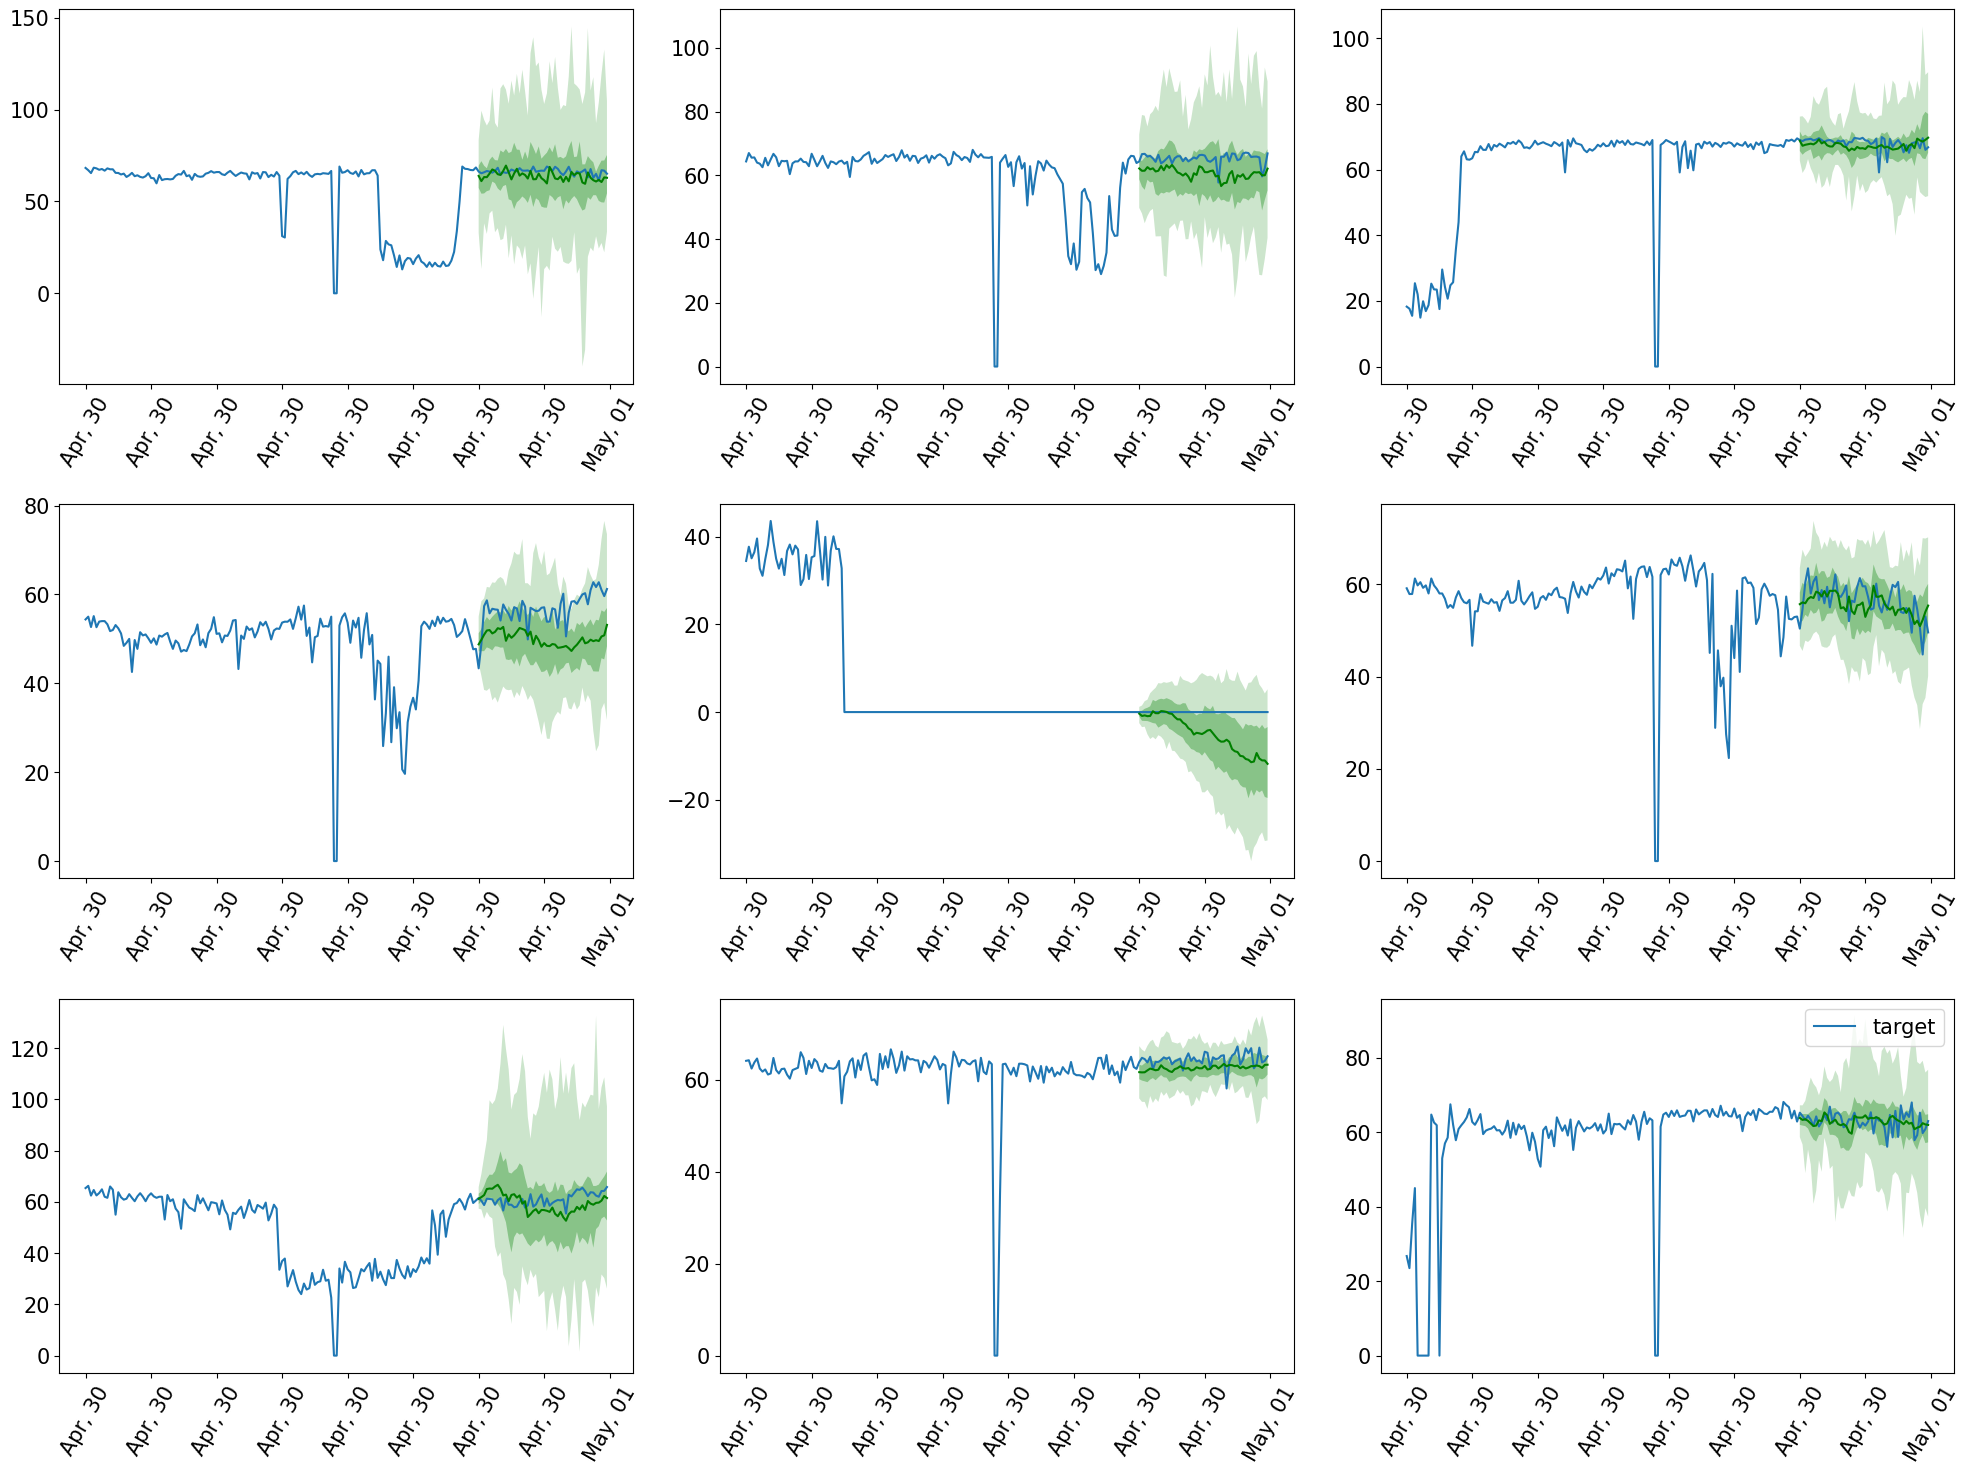

In [40]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

Coming Soon:

⭐ An <b>online gradio demo</b> where you can upload time series and get zero-shot predictions.

⭐ Features for <b>finetuning</b> the foundation model

⭐ Features for <b>pretraining</b> Lag-Llama on your own large-scale data

⭐ Scripts to <b>reproduce</b> all results in the paper.


____

Stay Tuned!🦙